<a href="https://colab.research.google.com/github/bongbolobong/-/blob/main/%EB%B4%89/Classfication/pytorch_arcface_gem_pooling_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<h2 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">[Pytorch] ArcFace Starter</h2>
<br>

![](https://media.istockphoto.com/illustrations/the-whale-is-blowing-illustration-id164494826?k=20&m=164494826&s=612x612&w=0&h=SGm8bwFqE7-h_ekqaXOVfIUIpKN8aW2AAMcFSbvpwYg=)

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;"><strong>Update:</strong></span><br>
<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">V3: Added Embedding layer between GeM pooling and ArcFace Module. Improves results</span>

<h3>📌 Siamese Starter Notebook:</h3> <h4><a href='https://www.kaggle.com/debarshichanda/pytorch-happywhale-siamese-starter'>https://www.kaggle.com/debarshichanda/pytorch-happywhale-siamese-starter</a></h4>

<h3>📌 FAISS Pytorch Inference:</h3> <h4><a href='https://www.kaggle.com/debarshichanda/faiss-pytorch-inference'>https://www.kaggle.com/debarshichanda/faiss-pytorch-inference</a></h4>

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Install Required Libraries</h1></span>

In [ ]:
!pip install timm
!pip install --upgrade wandb

     |████████████████████████████████| 431 kB 594 kB/s            
     |████████████████████████████████| 1.7 MB 594 kB/s            
  Attempting uninstall: wandb
    Found existing installation: wandb 0.12.9
    Uninstalling wandb-0.12.9:
      Successfully uninstalled wandb-0.12.9


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Import Required Libraries 📚</h1></span>

In [ ]:
import os
import gc
import cv2
import math
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;"> Weights & Biases (W&B) is a set of machine learning tools that helps you build better models faster. <strong>Kaggle competitions require fast-paced model development and evaluation</strong>. There are a lot of components: exploring the training data, training different models, combining trained models in different combinations (ensembling), and so on.</span>

> <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">⏳ Lots of components = Lots of places to go wrong = Lots of time spent debugging</span>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">W&B can be useful for Kaggle competition with it's lightweight and interoperable tools:</span>

* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Quickly track experiments,<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Version and iterate on datasets, <br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Evaluate model performance,<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Reproduce models,<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Visualize results and spot regressions,<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Share findings with colleagues.</span>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">To learn more about Weights and Biases check out this <strong><a href="https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases">kernel</a></strong>.</span>

In [ ]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Configuration ⚙️</h1></span>

In [ ]:
CONFIG = {"seed": 2022,
          "epochs": 4,
          "img_size": 448,
          "model_name": "tf_efficientnet_b0_ns",
          "num_classes": 15587,
          "embedding_size": 512,
          "train_batch_size": 32,
          "valid_batch_size": 64,
          "learning_rate": 1e-4,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 5,
          "n_accumulate": 1,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          # ArcFace Hyperparameters
          "s": 30.0, 
          "m": 0.50,
          "ls_eps": 0.0,
          "easy_margin": False
          }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Set Seed for Reproducibility</h1></span>

In [ ]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [ ]:
ROOT_DIR = '../input/happy-whale-and-dolphin'
TRAIN_DIR = '../input/happy-whale-and-dolphin/train_images'
TEST_DIR = '../input/happy-whale-and-dolphin/test_images'

In [ ]:
def get_train_file_path(id):
    return f"{TRAIN_DIR}/{id}"

# <h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Read the Data 📖</h1>

In [ ]:
df = pd.read_csv(f"{ROOT_DIR}/train.csv")
df['file_path'] = df['image'].apply(get_train_file_path)
df.head()

,image,species,individual_id,file_path
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,../input/happy-whale-and-dolphin/train_images/...
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,../input/happy-whale-and-dolphin/train_images/...
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,../input/happy-whale-and-dolphin/train_images/...
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,../input/happy-whale-and-dolphin/train_images/...
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,../input/happy-whale-and-dolphin/train_images/...


In [ ]:
encoder = LabelEncoder()
df['individual_id'] = encoder.fit_transform(df['individual_id'])

with open("le.pkl", "wb") as fp:
    joblib.dump(encoder, fp)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Folds</h1></span>

In [ ]:
skf = StratifiedKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(skf.split(X=df, y=df.individual_id)):
      df.loc[val_ , "kfold"] = fold

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [ ]:
class HappyWhaleDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df['individual_id'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [ ]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Code taken from <a href="https://amaarora.github.io/2020/08/30/gempool.html">GeM Pooling Explained</a></span>

![](https://i.imgur.com/thTgYWG.jpg)

In [ ]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">ArcFace</h1></span>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Code taken from <a href="https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/blob/master/src/modeling/metric_learning.py">Landmark2019-1st-and-3rd-Place-Solution</a></span>

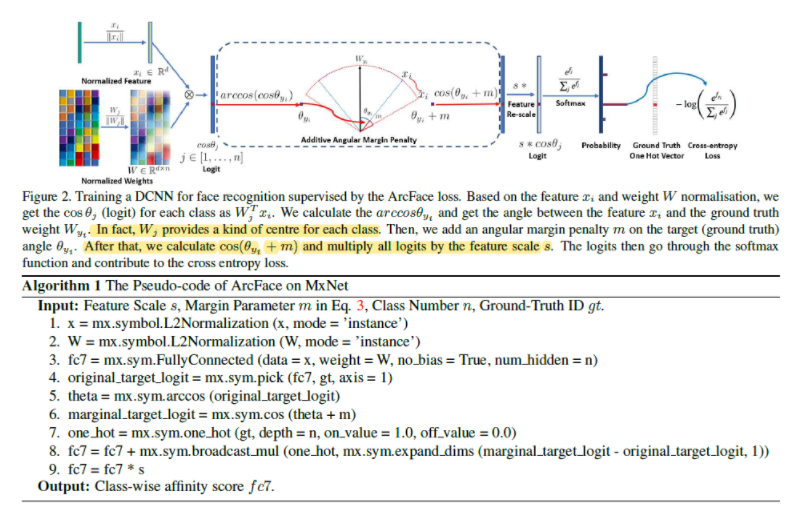

In [ ]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, 
                 m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight)) #(input, weight, bias=None) linear transformation  
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2)) # sin^2 +cos^2 = 1 
        phi = cosine * self.cos_m - sine * self.sin_m  # cos(x + y) = cosx * cosy + sinx * siny
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=CONFIG['device'])
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [ ]:
class HappyWhaleModel(nn.Module):
    def __init__(self, model_name, embedding_size, pretrained=True):
        super(HappyWhaleModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.embedding = nn.Linear(in_features, embedding_size)
        self.fc = ArcMarginProduct(embedding_size, 
                                   CONFIG["num_classes"],
                                   s=CONFIG["s"], 
                                   m=CONFIG["m"], 
                                   easy_margin=CONFIG["ls_eps"], 
                                   ls_eps=CONFIG["ls_eps"])

    def forward(self, images, labels):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        embedding = self.embedding(pooled_features)
        output = self.fc(embedding, labels)
        return output
    
    def extract(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        embedding = self.embedding(pooled_features)
        return embedding

    
model = HappyWhaleModel(CONFIG['model_name'], CONFIG['embedding_size'])
model.to(CONFIG['device']);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_ns-c0e6a31c.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_ns-c0e6a31c.pth


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function</h1></span>

In [ ]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Function</h1></span>

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)
        
        batch_size = images.size(0)
        
        outputs = model(images, labels)
        loss = criterion(outputs, labels)
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward() 
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Validation Function</h1></span>

In [ ]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)
        
        batch_size = images.size(0)

        outputs = model(images, labels)
        loss = criterion(outputs, labels)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "Loss{:.4f}_epoch{:.0f}.bin".format(best_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [ ]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [ ]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HappyWhaleDataset(df_train, transforms=data_transforms["train"])
    valid_dataset = HappyWhaleDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Prepare Dataloaders</span>

In [ ]:
train_loader, valid_loader = prepare_loaders(df, fold=0)

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Define Optimizer and Scheduler</span>

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Start Training</span>

In [ ]:
run = wandb.init(project='HappyWhale', 
                 config=CONFIG,
                 job_type='Train',
                 tags=['arcface', 'gem-pooling', 'effnet-b0-ns', '448'],
                 anonymous='must')

wandb: Currently logged in as: dchanda (use `wandb login --relogin` to force relogin)


In [ ]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])

[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 160/160 [10:30<00:00,  3.94s/it, Epoch=1, LR=4.28e-5, Valid_Loss=19.1]


Validation Loss Improved (inf ---> 19.062501627796017)
Model Saved



100%|██████████| 160/160 [10:36<00:00,  3.98s/it, Epoch=2, LR=3.42e-6, Valid_Loss=17.2]


Validation Loss Improved (19.062501627796017 ---> 17.23617388819742)
Model Saved



100%|██████████| 160/160 [10:38<00:00,  3.99s/it, Epoch=3, LR=7.3e-5, Valid_Loss=15]  


Validation Loss Improved (17.23617388819742 ---> 14.97029778211535)
Model Saved



100%|██████████| 160/160 [10:41<00:00,  4.01s/it, Epoch=4, LR=9.05e-5, Valid_Loss=14.9]


Validation Loss Improved (14.97029778211535 ---> 14.899353628680862)
Model Saved

Training complete in 3h 54m 47s
Best Loss: 14.8994


In [ ]:
run.finish()

Train Loss,█▄▁▁
Valid Loss,█▅▁▁
Best Loss,14.89935
Train Loss,14.79472
Valid Loss,14.89935


# <h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Visualizations</h1>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;"><a href="https://wandb.ai/dchanda/HappyWhale/runs/3l3k91tm">View the Complete Dashboard Here ⮕</a></span>

![](https://i.imgur.com/3Cc8KBH.jpg)

![Upvote!](https://img.shields.io/badge/Upvote-If%20you%20like%20my%20work-07b3c8?style=for-the-badge&logo=kaggle)